- https://www.rottentomatoes.com/top/bestofrt/?year=2020
- https://www.rottentomatoes.com/top/bestofrt/?year=1998
  - det er top 100 film fra et givent år

- Scrape navn, genre, runtime, tomatometer score og audience score på filmene fra årstallet 2020 og 1998
	- Hvis en film har flere genre så tilhører den alle de forskellige genre grupper

In [3]:
import bs4
import json
from concurrent.futures import ThreadPoolExecutor
import requests

def download(url):
  r = requests.get(url)
  if(r.status_code != 200):
    raise FileNotFoundError
  return bs4.BeautifulSoup(r.text, 'html.parser')
  
def multi_download(url_list):
  with ThreadPoolExecutor(5) as ex:
    return list(ex.map(download, url_list))

def get_top_movies_urls_by_year(year):
  url = 'https://www.rottentomatoes.com/top/bestofrt/?year='+year
  r = requests.get(url)
  soup = bs4.BeautifulSoup(r.text, 'html.parser')
  
  top_movies = soup.select_one('#jsonLdSchema').text
  jsondata = json.loads(top_movies)
  links = jsondata['itemListElement']
  
  urls = []
  for link in links:
    urls.append(link['url'])
  return urls

def get_movie_info_by_url(urls):
  if(urls != list):
    urls = list(urls)
  movies = multi_download(urls)
  movie_info = []
  for i in movies:
    script_tag = i.select_one('#score-details-json').text
    jsondata = json.loads(script_tag)
    title = jsondata['scoreboard']['title']
    audience_score = jsondata['scoreboard']['audienceScore']
    tomatometerScore = jsondata['scoreboard']['tomatometerScore']
    runtime = jsondata['scoreboard']['info'].split(',')[-1].strip()
    
    genres = i.find('div', 'meta-value genre')
    if(genres != None):
      genres_split = genres.text.strip().split(',')
      for i in genres_split:
        info = [title,audience_score,tomatometerScore,runtime,i.strip()]
        movie_info.append(info)
    else:
      info = [title,audience_score,tomatometerScore,runtime,'No genre']
      movie_info.append(info)
  return movie_info

movies_2020 = get_movie_info_by_url(get_top_movies_urls_by_year('2020'))
movies_1998 = get_movie_info_by_url(get_top_movies_urls_by_year('1998'))

In [2]:
import pandas as pd
df_1998 = pd.DataFrame(movies_1998, columns=['title','audience_score','tomatometer_score','runtime','genre'])
df_1998['year'] = '1998'
df_2020 = pd.DataFrame(movies_2020, columns=['title','audience_score','tomatometer_score','runtime','genre'])
df_2020['year'] = '2020'

NameError: name 'movies_1998' is not defined

- Vis den gennemsnitlige audience score for hver genre i 2020 og 1998, i den samme barchart

In [1]:
import matplotlib.pyplot as plt

average_1998 = df_1998['audience_score'].sum()/len(df_1998['audience_score'])
average_2020 = df_2020['audience_score'].sum()/len(df_2020['audience_score'])

plt.bar('1998', average_1998)
plt.bar('2020', average_2020)
print(average_1998, average_2020)
plt.show()

NameError: name 'df_1998' is not defined

- Find den genre hvor der er størst forskel fra audience score og tomatometer score i 1998
	- har det ændret sig i 2020?
	- hvis ja
		- vis en barchart af de forskellige genre

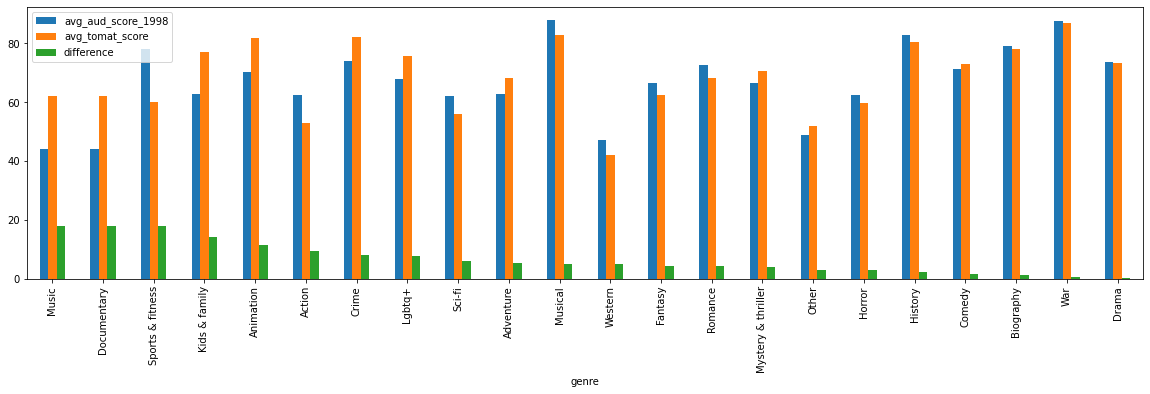

In [13]:
plt.rcParams["figure.figsize"] = (20,5)

unique_genres_1998 = pd.unique(df_1998['genre'])

averages_1998 = []
for genre in unique_genres_1998:
  averages_1998.append([genre,df_1998[df_1998['genre'] == genre]['audience_score'].sum()/len(df_1998[df_1998['genre'] == genre]),df_1998[df_1998['genre'] == genre]['tomatometer_score'].sum()/len(df_1998[df_1998['genre'] == genre])])

avg_aud_score_1998 = pd.DataFrame(averages_1998, columns=['genre','avg_aud_score_1998', 'avg_tomat_score'])

avg_aud_score_1998['difference'] = abs(avg_aud_score_1998['avg_aud_score_1998']-avg_aud_score_1998['avg_tomat_score'])
avg_aud_score_1998 = avg_aud_score_1998.sort_values(by='difference', ascending=False)
avg_aud_score_1998 = avg_aud_score_1998.set_index('genre')
avg_aud_score_1998.plot.bar()
# avg_aud_score_1998.head(10)
  
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

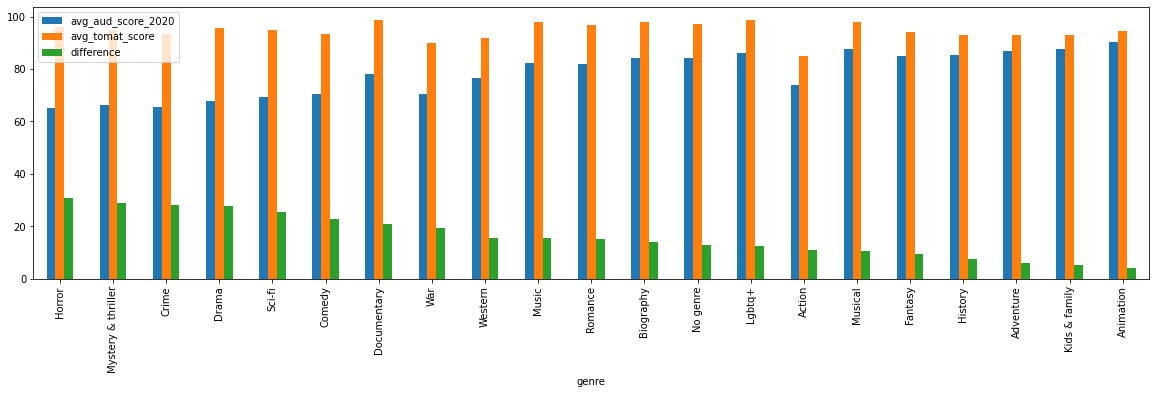

In [7]:
plt.rcParams["figure.figsize"] = (20,5)
unique_genres_2020 = pd.unique(df_2020['genre'])

averages_2020 = []
for genre in unique_genres_2020:
  averages_2020.append([genre,df_2020[df_2020['genre'] == genre]['audience_score'].sum()/len(df_2020[df_2020['genre'] == genre]),df_2020[df_2020['genre'] == genre]['tomatometer_score'].sum()/len(df_2020[df_2020['genre'] == genre])])

avg_aud_score_2020 = pd.DataFrame(averages_2020, columns=['genre','avg_aud_score_2020', 'avg_tomat_score'])

avg_aud_score_2020['difference'] = abs(avg_aud_score_2020['avg_aud_score_2020']-avg_aud_score_2020['avg_tomat_score'])
avg_aud_score_2020 = avg_aud_score_2020.sort_values(by='difference', ascending=False)
avg_aud_score_2020 = avg_aud_score_2020.set_index('genre')
avg_aud_score_2020.plot.bar()

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

- Hvad er den gennemsnitlige runtime for genren 'drama' i 1998 og 2020?"

In [8]:
def runtime_to_minutes(x):
  if len(x) < 2:
    return int(x[0][0:-1]) * 60
  else:
    return (int(x[0][0:-1]) * 60) + (int(x[1][0:-1]))

df_1998['runtime_minues'] = df_1998['runtime'].str.split(' ')
df_1998['runtime_minues'] = df_1998['runtime_minues'].apply(runtime_to_minutes)
df_1998[df_1998['genre'] == 'Drama']['runtime_minues'].sum()/len(df_1998[df_1998['genre'] == 'Drama']['runtime_minues'])

117.85714285714286

In [9]:
df_2020['runtime_minues'] = df_2020['runtime'].str.split(' ')
df_2020['runtime_minues'] = df_2020['runtime_minues'].apply(runtime_to_minutes)
df_2020[df_2020['genre'] == 'Drama']['runtime_minues'].sum()/len(df_2020[df_2020['genre'] == 'Drama']['runtime_minues'])

149.38095238095238